In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-05-14 22:56:46.805151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 22:56:46.805185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
# Load data
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/20200711_patchseq_metadata_mouse.csv")[['transcriptomics_sample_id', 't_type']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split()[0] for x in meta[meta_idx, 1]])

# Sampling
data_col_idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [5]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 250
pca_dim = [32, None]

# ComManDo

In [6]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': 'euclidean',
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.1364 alpha:0.0845
epoch:[1000/2000] err:0.1591 alpha:0.0993
epoch:[1500/2000] err:0.1722 alpha:0.1087
epoch:[2000/2000] err:0.1784 alpha:0.1148
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.159614
epoch:[1000/2000]: loss:0.933485
epoch:[1500/2000]: loss:0.885152
epoch:[2000/2000]: loss:0.877513
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.22638492201804183
Correspondence: 8.544366590009304
Mapping: 30.786520060006296
Total: 39.55727157203364

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:1.154497
epoch:[1000/2000]: loss:0.933008
epoch:[1500/2000]: loss:0.882326
epoch:[2000/20

# Comparison Methods

In [7]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
lma_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim, corr=half_priors)

# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
cca_data_half, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 1302)
Dataset 1: (500, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.1364 alpha:0.0845
epoch:[1000/2000] err:0.1591 alpha:0.0993
epoch:[1500/2000] err:0.1722 alpha:0.1087
epoch:[2000/2000] err:0.1784 alpha:0.1148
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:3.295668, align_loss:0.369602
epoch:[20/100]: loss:3.154625, align_loss:0.292194
epoch:[30/100]: loss:3.545927, align_loss:0.267438
epoch:[40/100]: loss:2.974563, align_loss:0.239922
epoch:[50/100]: loss:2.630797, align_loss:0.216694
epoch:[60/100]: loss:2.631343, align_loss:0.208006
epoch:[70/100]: loss:3.049959, align_loss:0.176046
epoch:[80/100]: loss:2.969768, align_loss:0.192204
epoch:[90/100]: loss:2.717518, align_loss:0.133724
epoch:[100/100]: loss:2.325246, align_loss:0.123428
Done
---------------------------------
ComManDo Done!
D

# Figure Generation

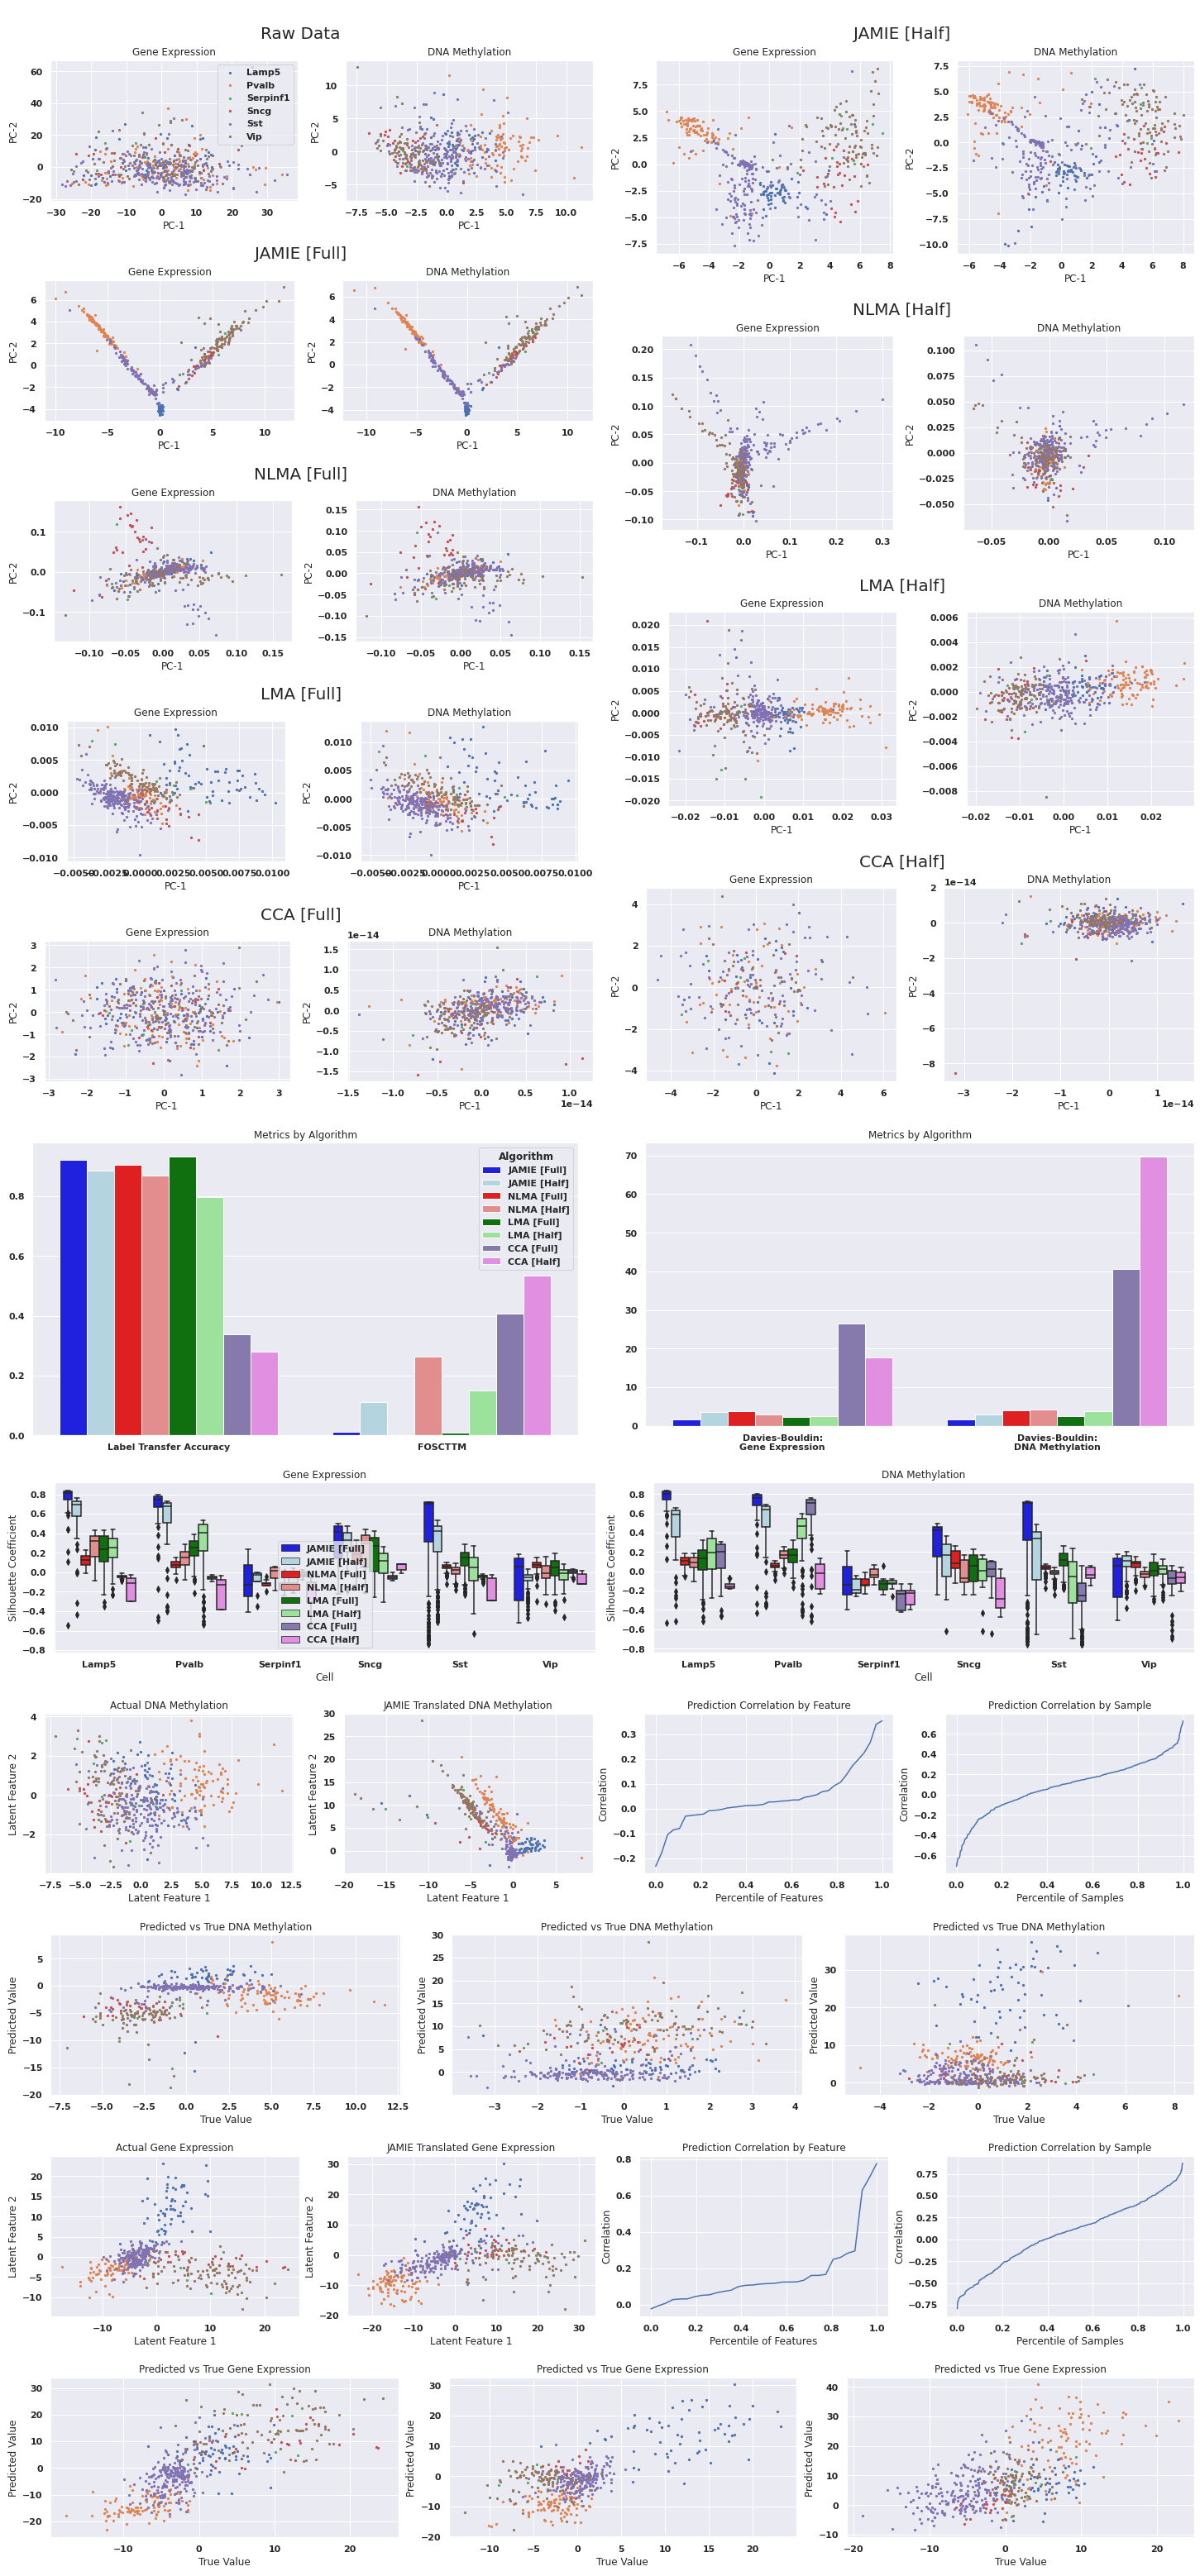

In [8]:
#%%capture --no-display
# https://miro.medium.com/max/800/1*zm6zVTIEvf9uZ0cE4n0Ogg.png
params = {
    'dataset_names': ['Gene Expression', 'DNA Methylation'],
    'integrated_data': [cm_data, cm_data_half, nlma_data, nlma_data_half, lma_data, lma_data_half, cca_data, cca_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'NLMA [Full]', 'NLMA [Half]', 'LMA [Full]', 'LMA [Half]', 'CCA [Full]', 'CCA [Half]'],
    'colors': ['blue', 'lightblue', 'red', 'lightcoral', 'green', 'lightgreen', 'm', 'violet'],
    'alg_groups': [0, 1, 0, 1, 0, 1, 0, 1],
    'raw_data_group': 0,
    'scale': 20,
    'integrated_use_pca': True,
    # 'exclude_predict': [(0, 1)],
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params);